In [74]:
import os
import PyPDF2
import pandas as pd

In [75]:
PDFS_DIR = "./pdfs/"

pdfs_processed = []
for root, dirs, files in os.walk(PDFS_DIR, topdown=False):
    for name in files:
        pdfs_processed.append({'path':os.path.join(root, name), 'name':name.split(".")[0].split("_")[0], 'id':name.split(".")[0].split("_")[1]})

In [76]:
texts = []
names = []
ids   = []

data = []

for pdf in pdfs_processed:

    with open(pdf['path'],'rb') as pdf_file:
 
        pdfreader = PyPDF2.PdfReader(pdf_file)

        x = len(pdfreader.pages)

        pageobj=pdfreader.pages[0] # -> x + 1 because python start in 0, so 0 + 1 => page 1 (start)

        point = [pdf['id'], pdf['name'], pageobj.extract_text().replace("[", "(").replace("]", ")")]
        
        data.append(point)
        
    pdf_file.close()



In [77]:
pdf_df = pd.DataFrame(data, columns=['text_id', 'title', 'text'])

In [78]:
pdf_df

,text_id,title,text
0,1802,Addressing-Function-Approximation-Error-In-Act...,Addressing Function Approximation Error in Act...
1,1706,Attention-is-All-you-need,Attention Is All You Need\nAshish Vaswani\nGo...
2,20130129,blake2,"BLAKE2: simpler, smaller, fast as MD5\n2013.01..."
3,1509,Deep-Reinforcement-Learning-with-Double-Q-lear...,Deep Reinforcement Learning with Double Q-lear...
4,1710,Distributional-Reinforcement-Learning-With-Qua...,Distributional Reinforcement Learning with Qua...
5,1511,Dueling-Network-Architectures-For-Deep-reingor...,Dueling Network Architectures for Deep Reinfor...
6,2010,GeneticAlgo,Logic Guided Genetic Algorithms\nDhananjay Ash...
7,1710,Rainbow-Combining-Improvements-In-Deep-Reinfor...,Rainbow: Combining Improvements in Deep Reinfo...
8,,whisper,Robust Speech Recognition via Large-Scale Weak...


In [79]:
from sentence_transformers import SentenceTransformer

def embed_text(text): 
    
    # model = SentenceTransformer('all-mpnet-base-v2')
    model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

    response = model.encode(text, convert_to_tensor=True)

    response = response.cpu().detach().numpy()

    return response

In [80]:
pdf_df['text_vector'] = pdf_df['text'].apply(embed_text)

In [81]:
import seaborn as sns
from sklearn.decomposition import PCA

In [82]:
# retrieve the embedding vectors from the search results
vectors = pdf_df.loc[:, "text_vector"].to_list()

# apply PCA to reduce the dimensionality of the vectors to 3 dimensions
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(vectors)

# create a dataframe with the reduced vectors
new_pca_df = pd.DataFrame(reduced_vectors, columns=['PC1', 'PC2', 'PC3'])

new_pca_df['text_lenght'] = pdf_df['text'].apply(len)
new_pca_df['title'] = pdf_df['title']

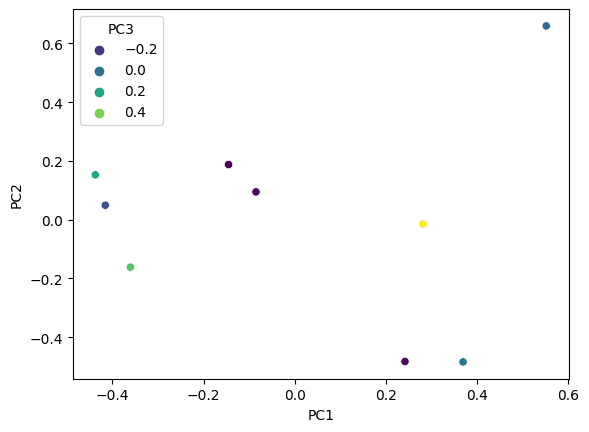

In [83]:
# for creating a responsive plot
import ipympl
%matplotlib widget
%matplotlib inline

# use seaborn's scatterplot function to visualize the clusters
sns.scatterplot(data=new_pca_df, x='PC1', y='PC2', hue='PC3', palette='viridis')

import matplotlib.pyplot as plt
plt.show()

In [85]:
import plotly.express as px

# Configure the trace.
fig = px.scatter_3d(new_pca_df,
    x='PC1',  # <-- Put your data instead
    y='PC2',  # <-- Put your data instead
    z='PC3',  # <-- Put your data instead
    size='text_lenght',
    color='title'
)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()